In [29]:
import math
import numpy as np
import pandas as pd
import pandasql as ps
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype
import IPython.display as ipd
from tqdm.notebook import tqdm, trange
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
import ast

from collections import defaultdict
from scipy.stats.stats import pearsonr

plt.rcParams['axes.formatter.useoffset']=False
pd.set_option('display.max_columns', None)
#plt.rcParams['figure.figsize'] = [20, 10]
#plt.rcParams['figure.dpi'] = 50

# Preparazione DF

In [30]:
df = pd.read_csv('flat_df_no_nulli.csv', index_col=0)

In [31]:
#Definisco i vari tipi di dati che abbiamo nel df

features = [
 'chroma_censkurtosis',
 'chroma_censmax',
 'chroma_censmean',
 'chroma_censmedian',
 'chroma_censmin',
 'chroma_censskew',
 'chroma_censstd',
 'chroma_censcqtkurtosis',
 'chroma_cqtmax',
 'chroma_cqtmean',
 'chroma_cqtmedian',
 'chroma_cqtmin',
 'chroma_cqtskew',
 'chroma_cqtstd',
 'chroma_stftkurtosis',
 'chroma_stftmax',
 'chroma_stftmean',
 'chroma_stftmedian',
 'chroma_stftmin',
 'chroma_stftskew',
 'chroma_stftstd',
 'mfcckurtosis',
 'mfccmax',
 'mfccmean',
 'mfccmedian',
 'mfccmin',
 'mfccskew',
 'mfccstd',
 'spectral_contrastkurtosis',
 'spectral_contrastmax',
 'spectral_contrastmean',
 'spectral_contrastmedian',
 'spectral_contrastmin',
 'spectral_contrastskew',
 'spectral_contraststd',
 'tonnetzkurtosis',
 'tonnetzmax',
 'tonnetzmean',
 'tonnetzmedian',
 'tonnetzmin',
 'tonnetzskew',
 'tonnetzstd',
 'rmsekurtosis01',
 'rmsemax01',
 'rmsemean01',
 'rmsemedian01',
 'rmsemin01',
 'rmseskew01',
 'rmsestd01',
 'spectral_bandwidthkurtosis01',
 'spectral_bandwidthmax01',
 'spectral_bandwidthmean01',
 'spectral_bandwidthmedian01',
 'spectral_bandwidthmin01',
 'spectral_bandwidthskew01',
 'spectral_bandwidthstd01',
 'spectral_centroidkurtosis01',
 'spectral_centroidmax01',
 'spectral_centroidmean01',
 'spectral_centroidmedian01',
 'spectral_centroidmin01',
 'spectral_centroidskew01',
 'spectral_centroidstd01',
 'spectral_rolloffkurtosis01',
 'spectral_rolloffmax01',
 'spectral_rolloffmean01',
 'spectral_rolloffmedian01',
 'spectral_rolloffmin01',
 'spectral_rolloffskew01',
 'spectral_rolloffstd01',
 'zcrkurtosis01',
 'zcrmax01',
 'zcrmean01',
 'zcrmedian01',
 'zcrmin01',
 'zcrskew01',
 'zcrstd01',
]


bitmap = [
    'Blues',
 'Classical',
 'Country',
 'Easy Listening',
 'Electronic',
 'Experimental',
 'Folk',
 'Hip-Hop',
 'Instrumental',
 'International',
 'Jazz',
 'Old-Time / Historic',
 'Pop',
 'Rock',
 'Soul-RnB',
 'Spoken',
]

nulli = [
     'ALBUM_date_released_year',
    'ALBUM_favorites',
     'ALBUM_listens',
 'ALBUM_tracks',
 'ALBUM_type',
 'ARTIST_favorites',
 'ARTIST_location',
 'TRACK_favorites',
  'ARTIST_location_',
    'TRACK_genres_soloTop'
]

nonNumerici = [
    'ALBUM_tags',
    'ALBUM_title',
    'ARTIST_location_',
    'ARTIST_name',
    'ARTIST_tags',
    'SET_subset',
    'TRACK_genre_top',
    'TRACK_genres',
    'TRACK_genres_all',
    'TRACK_genres_soloTop',
    'TRACK_tags',
    'TRACK_title',
    'TRACK_genres_soloTop'
]

def Diff(li1, li2):
    return list(set(li1)-set(li2))

tutti = list(df.columns)

compl = Diff(tutti, features + bitmap + nonNumerici + nulli+ ['target'])

compl.sort()

compl

['ALBUM_date_released_year_',
 'ALBUM_favorites_',
 'ALBUM_listens_',
 'ALBUM_tracks_',
 'ALBUM_type_',
 'ARTIST_favorites_',
 'TRACK_bitrate',
 'TRACK_duration',
 'TRACK_interest',
 'TRACK_listens',
 'TRACK_number']

In [32]:
#trasformo TRACK_genres da stringa a lista

def trasformaLista(stringa):
    result = list()
    tmp = stringa[1 : len(stringa)-1]
    
    splitted = tmp.split(", ")
    
    for s in splitted:
        try:
            result.append(int(s[1:-1]))
        except:
            pass#result.append(np.NaN)
    
    return result



tmp = list();

for index in tqdm(df.index):
    #print(df[df.index == index].TRACK_genres.iloc[0])
    daTrasformare = df[df.index == index].TRACK_genres.iloc[0]
    tmp.append(trasformaLista(daTrasformare))
    
df["TRACK_genres"] = tmp

In [33]:
#mappa genre_id --> genre_top
genres = pd.read_csv('fma_metadata_progetto/genres.csv', index_col=0)

#generiDic = {}
#for genreIndex in genres.index:
#    generiDic[genreIndex] = genres[genres.index == genres[genres.index == genreIndex].top_level.iloc[0]].title.iloc[0]

generiDic = {1: 'Experimental',
                 2: 'International',
                 3: 'Blues',
                 4: 'Jazz',
                 5: 'Classical',
                 6: 'Experimental',
                 7: 'Spoken',
                 8: 'Old-Time / Historic',
                 9: 'Country',
                 10: 'Pop',
                 11: 'Soul-RnB',
                 12: 'Rock',
                 13: 'Easy Listening',
                 14: 'Soul-RnB',
                 15: 'Electronic',
                 16: 'Experimental',
                 17: 'Folk',
                 18: 'Instrumental',
                 19: 'Soul-RnB',
                 20: 'Spoken',
                 21: 'Hip-Hop',
                 22: 'Experimental',
                 25: 'Rock',
                 26: 'Rock',
                 27: 'Rock',
                 30: 'Experimental',
                 31: 'Rock',
                 32: 'Experimental',
                 33: 'Folk',
                 36: 'Rock',
                 37: 'Jazz',
                 38: 'Experimental',
                 41: 'Experimental',
                 42: 'Electronic',
                 43: 'Spoken',
                 45: 'Rock',
                 46: 'International',
                 47: 'Experimental',
                 49: 'Folk',
                 53: 'Rock',
                 58: 'Rock',
                 63: 'Country',
                 64: 'Rock',
                 65: 'Spoken',
                 66: 'Rock',
                 70: 'Rock',
                 71: 'Rock',
                 74: 'Jazz',
                 76: 'Pop',
                 77: 'International',
                 79: 'International',
                 81: 'International',
                 83: 'Hip-Hop',
                 85: 'Rock',
                 86: 'International',
                 88: 'Rock',
                 89: 'Rock',
                 90: 'Rock',
                 92: 'International',
                 94: 'Folk',
                 97: 'Jazz',
                 98: 'Rock',
                 100: 'Hip-Hop',
                 101: 'Rock',
                 102: 'International',
                 103: 'Folk',
                 107: 'Instrumental',
                 109: 'Rock',
                 111: 'Rock',
                 113: 'Rock',
                 117: 'International',
                 118: 'International',
                 125: 'Experimental',
                 130: 'International',
                 137: 'Country',
                 138: 'Spoken',
                 166: 'Spoken',
                 167: 'Rock',
                 169: 'Country',
                 170: 'Easy Listening',
                 171: 'International',
                 172: 'International',
                 173: 'International',
                 174: 'International',
                 175: 'International',
                 176: 'International',
                 177: 'International',
                 178: 'Jazz',
                 179: 'Jazz',
                 180: 'Folk',
                 181: 'Electronic',
                 182: 'Electronic',
                 183: 'Electronic',
                 184: 'Electronic',
                 185: 'Electronic',
                 186: 'Experimental',
                 187: 'Classical',
                 188: 'Spoken',
                 189: 'Spoken',
                 214: 'International',
                 224: 'Experimental',
                 232: 'International',
                 236: 'Electronic',
                 240: 'Electronic',
                 247: 'Experimental',
                 250: 'Experimental',
                 267: 'Instrumental',
                 286: 'Electronic',
                 296: 'Electronic',
                 297: 'Electronic',
                 311: 'Easy Listening',
                 314: 'Rock',
                 322: 'Classical',
                 337: 'Electronic',
                 359: 'Rock',
                 360: 'Experimental',
                 361: 'Rock',
                 362: 'Pop',
                 374: 'Spoken',
                 377: 'Soul-RnB',
                 378: 'Spoken',
                 400: 'Electronic',
                 401: 'Electronic',
                 404: 'Rock',
                 428: 'Spoken',
                 439: 'Rock',
                 440: 'Rock',
                 441: 'Classical',
                 442: 'Classical',
                 443: 'Classical',
                 444: 'Classical',
                 456: 'Experimental',
                 465: 'Spoken',
                 468: 'Electronic',
                 491: 'Electronic',
                 493: 'Country',
                 495: 'Electronic',
                 502: 'International',
                 504: 'International',
                 514: 'Experimental',
                 524: 'International',
                 538: 'Instrumental',
                 539: 'Hip-Hop',
                 542: 'Hip-Hop',
                 567: 'Blues',
                 580: 'Hip-Hop',
                 602: 'International',
                 619: 'International',
                 651: 'Country',
                 659: 'Classical',
                 693: 'Hip-Hop',
                 695: 'Electronic',
                 741: 'International',
                 763: 'Experimental',
                 808: 'International',
                 810: 'Easy Listening',
                 811: 'Hip-Hop',
                 906: 'Jazz',
                 1032: 'International',
                 1060: 'International',
                 1156: 'International',
                 1193: 'Experimental',
                 1235: 'Instrumental'
            }

In [34]:
#estrazione dei generi "radice" da "TRACK_genres" senza duplicati

list1 = list()
list1_len = list()

for track in tqdm(tmp):
    top = list()
    for genreid in track:
        try:
            resolved = generiDic[int(genreid)]
            if resolved not in top:
                top.append(resolved)
        except:
            pass#top = np.NaN
            
    list1.append(top)
    list1_len.append(len(top))

df["TRACK_genres_soloTop"] = list1 
df["TRACK_genres_soloTop_len"] = list1_len

In [35]:
df0 = df[["TRACK_genres_soloTop_len", "TRACK_genres_soloTop", "TRACK_genre_top", "TRACK_genres"]]

df0

,TRACK_genres_soloTop_len,TRACK_genres_soloTop,TRACK_genre_top,TRACK_genres
track_id,,,,
2,1,[Hip-Hop],Hip-Hop,[21]
3,1,[Hip-Hop],Hip-Hop,[21]
5,1,[Hip-Hop],Hip-Hop,[21]
10,1,[Pop],Pop,[10]
20,2,"[Pop, Folk]",NaN,"[76, 103]"
...,...,...,...,...
155316,1,[Rock],Rock,[25]
155317,1,[Rock],Rock,[25]
155318,1,[Rock],Rock,[25]


In [36]:
#Elimino le features presenti (a cui era stata applicata la PCA) e reinserisco quelle originali

featuresdf = pd.read_csv('fma_metadata_progetto/features.csv', index_col=0, header=[0, 1, 2])

flat_features = pd.DataFrame()

for l1 in featuresdf.columns:
    name = "FEATURES_"
    for l2 in l1:
        name = name + l2
        
    flat_features[name] = featuresdf[l1]
    
df = pd.merge(df, flat_features, left_index=True, right_index=True)


#Ricalcolo compl
def Diff(li1, li2):
    return list(set(li1)-set(li2))

tutti = list(df.columns)

compl = Diff(tutti, features + bitmap + nonNumerici + nulli+ ['target'])

compl


df

,ALBUM_date_released_year,ALBUM_favorites,ALBUM_type,ALBUM_tags,ALBUM_tracks,ALBUM_listens,ALBUM_title,SET_subset,ARTIST_favorites,ARTIST_location,ARTIST_tags,ARTIST_name,TRACK_duration,TRACK_favorites,TRACK_genre_top,TRACK_genres_all,TRACK_genres,TRACK_interest,TRACK_listens,TRACK_tags,TRACK_title,TRACK_bitrate,TRACK_number,rmsekurtosis01,rmsemax01,rmsemean01,rmsemedian01,rmsemin01,rmseskew01,rmsestd01,spectral_bandwidthkurtosis01,spectral_bandwidthmax01,spectral_bandwidthmean01,spectral_bandwidthmedian01,spectral_bandwidthmin01,spectral_bandwidthskew01,spectral_bandwidthstd01,spectral_centroidkurtosis01,spectral_centroidmax01,spectral_centroidmean01,spectral_centroidmedian01,spectral_centroidmin01,spectral_centroidskew01,spectral_centroidstd01,spectral_rolloffkurtosis01,spectral_rolloffmax01,spectral_rolloffmean01,spectral_rolloffmedian01,spectral_rolloffmin01,spectral_rolloffskew01,spectral_rolloffstd01,zcrkurtosis01,zcrmax01,zcrmean01,zcrmedian01,zcrmin01,zcrskew01,zcrstd01,TRACK_genres_soloTop,ARTIST_favorites_,ALBUM_tracks_,ALBUM_listens_,ALBUM_favorites_,ALBUM_type_,ALBUM_date_released_year_,Blues,Classical,Country,Easy Listening,Electronic,Experimental,Folk,Hip-Hop,Instrumental,International,Jazz,Old-Time / Historic,Pop,Rock,Soul-RnB,Spoken,chroma_censkurtosis,chroma_censmax,chroma_censmean,chroma_censmedian,chroma_censmin,chroma_censskew,chroma_censstd,chroma_censcqtkurtosis,chroma_cqtmax,chroma_cqtmean,chroma_cqtmedian,chroma_cqtmin,chroma_cqtskew,chroma_cqtstd,chroma_stftkurtosis,chroma_stftmax,chroma_stftmean,chroma_stftmedian,chroma_stftmin,chroma_stftskew,chroma_stftstd,mfcckurtosis,mfccmax,mfccmean,mfccmedian,mfccmin,mfccskew,mfccstd,spectral_contrastkurtosis,spectral_contrastmax,spectral_contrastmean,spectral_contrastmedian,spectral_contrastmin,spectral_contrastskew,spectral_contraststd,tonnetzkurtosis,tonnetzmax,tonnetzmean,tonnetzmedian,tonnetzmin,tonnetzskew,tonnetzstd,ARTIST_location_,TRACK_genres_soloTop_len,FEATURES_chroma_censkurtosis01,FEATURES_chroma_censkurtosis02,FEATURES_chroma_censkurtosis03,FEATURES_chroma_censkurtosis04,FEATURES_chroma_censkurtosis05,FEATURES_chroma_censkurtosis06,FEATURES_chroma_censkurtosis07,FEATURES_chroma_censkurtosis08,FEATURES_chroma_censkurtosis09,FEATURES_chroma_censkurtosis10,FEATURES_chroma_censkurtosis11,FEATURES_chroma_censkurtosis12,FEATURES_chroma_censmax01,FEATURES_chroma_censmax02,FEATURES_chroma_censmax03,FEATURES_chroma_censmax04,FEATURES_chroma_censmax05,FEATURES_chroma_censmax06,FEATURES_chroma_censmax07,FEATURES_chroma_censmax08,FEATURES_chroma_censmax09,FEATURES_chroma_censmax10,FEATURES_chroma_censmax11,FEATURES_chroma_censmax12,FEATURES_chroma_censmean01,FEATURES_chroma_censmean02,FEATURES_chroma_censmean03,FEATURES_chroma_censmean04,FEATURES_chroma_censmean05,FEATURES_chroma_censmean06,FEATURES_chroma_censmean07,FEATURES_chroma_censmean08,FEATURES_chroma_censmean09,FEATURES_chroma_censmean10,FEATURES_chroma_censmean11,FEATURES_chroma_censmean12,FEATURES_chroma_censmedian01,FEATURES_chroma_censmedian02,FEATURES_chroma_censmedian03,FEATURES_chroma_censmedian04,FEATURES_chroma_censmedian05,FEATURES_chroma_censmedian06,FEATURES_chroma_censmedian07,FEATURES_chroma_censmedian08,FEATURES_chroma_censmedian09,FEATURES_chroma_censmedian10,FEATURES_chroma_censmedian11,FEATURES_chroma_censmedian12,FEATURES_chroma_censmin01,FEATURES_chroma_censmin02,FEATURES_chroma_censmin03,FEATURES_chroma_censmin04,FEATURES_chroma_censmin05,FEATURES_chroma_censmin06,FEATURES_chroma_censmin07,FEATURES_chroma_censmin08,FEATURES_chroma_censmin09,FEATURES_chroma_censmin10,FEATURES_chroma_censmin11,FEATURES_chroma_censmin12,FEATURES_chroma_censskew01,FEATURES_chroma_censskew02,FEATURES_chroma_censskew03,FEATURES_chroma_censskew04,FEATURES_chroma_censskew05,FEATURES_chroma_censskew06,FEATURES_chroma_censskew07,FEATURES_chroma_censskew08,FEATURES_chroma_censskew09,FEATURES_chroma_censskew10,FEATURES_chroma_censskew11,FEATURES_chroma_censskew12,FEATURES_chroma_censstd01,FEATURES_chroma_cen

In [37]:
#ottengo i dummies dai categorici

bitmaps = {}
bitmaps[0] = pd.get_dummies(df["ALBUM_date_released_year_"].apply(pd.Series).stack()).sum(level=0).add_prefix('ALBUM_date_released_year_=')

bitmaps[1] = pd.get_dummies(df["ALBUM_tracks_"].apply(pd.Series).stack()).sum(level=0).add_prefix('ALBUM_tracks_=')

bitmaps[2] = pd.get_dummies(df["ALBUM_type_"].apply(pd.Series).stack()).sum(level=0).add_prefix('ALBUM_type_=')
bitmaps[3] = pd.get_dummies(df["TRACK_bitrate"].apply(pd.Series).stack()).sum(level=0).add_prefix('TRACK_bitrate=')


for i in range(4):
    df = pd.concat([df, bitmaps[i]], axis=1)

    
df.drop(columns=["ALBUM_date_released_year_", 'ALBUM_tracks_', 'ALBUM_type_', 'TRACK_bitrate'], inplace=True)


#Ricalcolo compl
def Diff(li1, li2):
    return list(set(li1)-set(li2))

tutti = list(df.columns)

compl = Diff(tutti, features + bitmap + nonNumerici + nulli+ ['target'])

#df_riservato = df[:10000]
#df = df[10000:]

## Aggiunta rumore

Vengono aggiunti elementi alla lista TRACK_genres_soloTop in maniera random fino al raggiungimento di una soglia.

Idea alternativa sarebbe quella di usare la NN trovata al task precedente (stesso task di classificazione, ma senza TRACK_genres in input che contiene praticamente il risultato) e aggiungere alla lista TRACK_genres_soloTop i generi più probabili fino al reggiungimento della soglia

In [38]:
# Aggiungo rumore a TRACK_genres_soloTop

df_tmp = df.copy()

import random

top_genres_list = genres[genres.index == genres.top_level].title.values

def generaRumore(lst, targetLen, top_genres_list=top_genres_list):
    if len(lst) == targetLen:
        return lst
    
    scelto = random.choice(top_genres_list)
    
    if scelto in lst:
        return generaRumore(lst, targetLen, top_genres_list)
    else:
        return generaRumore(lst+[scelto], targetLen, top_genres_list)



def applicaRumoreDataFrame(list1, targetLen):
    list2 = list()
    list2_len = list()

    for i in tqdm(list1):
        if len(i) < targetLen:
            list2.append(generaRumore(i, targetLen, top_genres_list))
            list2_len.append(targetLen)
        else:
            list2.append(i)
            list2_len.append(len(i))
    
    return (list2, list2_len)

In [39]:
list2, list2_len = applicaRumoreDataFrame(list1, 3)

df_tmp["TRACK_genres_soloTop2"] = list2
df_tmp["TRACK_genres_soloTop_len2"] = list2_len

df = df_tmp

In [40]:
df

ALBUM_date_released_year  ALBUM_favorites        ALBUM_type  \
track_id                                                                
2                           2009.0              4.0             Album   
3                           2009.0              4.0             Album   
5                           2009.0              4.0             Album   
10                          2008.0              4.0             Album   
20                          2009.0              2.0             Album   
...                            ...              ...               ...   
155316                      2017.0              0.0  Live Performance   
155317                      2017.0              0.0  Live Performance   
155318                      2017.0              0.0  Live Performance   
155319                      2017.0              0.0  Live Performance   
155320                      2017.0              1.0             Album   

                                                 ALBUM_tags  ALBUM_tracks  \
track_id                                                                    
2                                                        []           7.0   
3                                                        []           7.0   
5                                                        []           7.0   
10                                                       []           2.0   
20                                                       []          13.0   
...                                                     ...           ...   
155316                                                   []           6.0   
155317                                                   []           6.0   
155318                                                   []           6.0   
155319                                                   []           6.0   
155320    ['ballad', 'epic', 'rockabilly', 'curse', 'hex...          11.0   

          ALBUM_listens                    ALBUM_title SET_subset  \
track_id                                                            
2                6073.0           AWOL - A Way Of Life      small   
3                6073.0           AWOL - A Way Of Life     medium   
5                6073.0           AWOL - A Way Of Life      small   
10              47632.0              Constant Hitmaker      small   
20               2710.0                          Niris      large   
...                 ...                            ...        ...   
155316           1506.0  Live at Monty Hall, 2/17/2017      large   
155317           1506.0  Live at Monty Hall, 2/17/2017      large   
155318           1506.0  Live at Monty Hall, 2/17/2017      large   
155319           1506.0  Live at Monty Hall, 2/17/2017      large   
155320           7481.0      What I Tell Myself Vol. 2      large   

          ARTIST_favorites        ARTIST_location  \
track_id                                            
2                 2.302585             New Jersey   
3                 2.302585             New Jersey   
5                 2.302585             New Jersey   
10                4.317488                    NaN   
20                2.397895     Colchester England   
...                    ...                    ...   
155316            0.000000             New Jersey   
155317            0.000000             New Jersey   
155318            0.000000             New Jersey   
155319            0.000000             New Jersey   
155320            2.564949  Jersey City, NJ 07302   

                                                ARTIST_tags       ARTIST_name  \
track_id                                                                        
2                                                  ['awol']              AWOL   
3                                                  ['awol']              AWOL   
5                                                  ['awol']              AWOL   
10                                  ['philly', 'kurt vile']      

In [41]:
df1 = df[["TRACK_genres_soloTop_len", "TRACK_genres_soloTop", "TRACK_genre_top", "TRACK_genres", "TRACK_genres_soloTop2", "TRACK_genres_soloTop_len2"]]

df1

,TRACK_genres_soloTop_len,TRACK_genres_soloTop,TRACK_genre_top,TRACK_genres,TRACK_genres_soloTop2,TRACK_genres_soloTop_len2
track_id,,,,,,
2,1,[Hip-Hop],Hip-Hop,[21],"[Hip-Hop, Jazz, Electronic]",3
3,1,[Hip-Hop],Hip-Hop,[21],"[Hip-Hop, Soul-RnB, Country]",3
5,1,[Hip-Hop],Hip-Hop,[21],"[Hip-Hop, Instrumental, Country]",3
10,1,[Pop],Pop,[10],"[Pop, Old-Time / Historic, Spoken]",3
20,2,"[Pop, Folk]",NaN,"[76, 103]","[Pop, Folk, Electronic]",3
...,...,...,...,...,...,...
155316,1,[Rock],Rock,[25],"[Rock, Instrumental, Folk]",3
155317,1,[Rock],Rock,[25],"[Rock, Electronic, Pop]",3
155318,1,[Rock],Rock,[25],"[Rock, Experimental, Country]",3


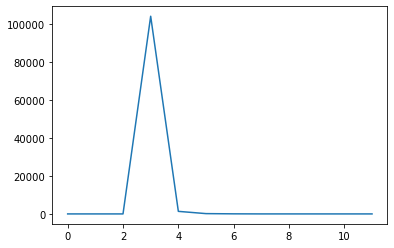

In [42]:
conta_len = []
for i in range(12):
    conta_len.append(len(df[df.TRACK_genres_soloTop_len2 == i].index))
    
plt.plot(conta_len)

In [43]:
conta_len

[0, 0, 0, 103986, 1346, 157, 42, 3, 1, 0, 0, 0]

In [44]:
#trasformo TRACK_genres_soloTop2 da lista a "bitmap" e elimino gli attributi che non mi servono più

df = df.drop(columns=bitmap)

df2 = pd.get_dummies(df["TRACK_genres_soloTop2"].apply(pd.Series).stack()).sum(level=0)
df = pd.concat([df, df2], axis=1)

df = df.drop(columns=["TRACK_genres_soloTop_len", 
                      "TRACK_genres_soloTop", 
                      "TRACK_genres", 
                      "TRACK_genres_soloTop2", 
                      "TRACK_genres_soloTop2",
                      "TRACK_genres_soloTop_len2"])

df

ALBUM_date_released_year  ALBUM_favorites        ALBUM_type  \
track_id                                                                
2                           2009.0              4.0             Album   
3                           2009.0              4.0             Album   
5                           2009.0              4.0             Album   
10                          2008.0              4.0             Album   
20                          2009.0              2.0             Album   
...                            ...              ...               ...   
155316                      2017.0              0.0  Live Performance   
155317                      2017.0              0.0  Live Performance   
155318                      2017.0              0.0  Live Performance   
155319                      2017.0              0.0  Live Performance   
155320                      2017.0              1.0             Album   

                                                 ALBUM_tags  ALBUM_tracks  \
track_id                                                                    
2                                                        []           7.0   
3                                                        []           7.0   
5                                                        []           7.0   
10                                                       []           2.0   
20                                                       []          13.0   
...                                                     ...           ...   
155316                                                   []           6.0   
155317                                                   []           6.0   
155318                                                   []           6.0   
155319                                                   []           6.0   
155320    ['ballad', 'epic', 'rockabilly', 'curse', 'hex...          11.0   

          ALBUM_listens                    ALBUM_title SET_subset  \
track_id                                                            
2                6073.0           AWOL - A Way Of Life      small   
3                6073.0           AWOL - A Way Of Life     medium   
5                6073.0           AWOL - A Way Of Life      small   
10              47632.0              Constant Hitmaker      small   
20               2710.0                          Niris      large   
...                 ...                            ...        ...   
155316           1506.0  Live at Monty Hall, 2/17/2017      large   
155317           1506.0  Live at Monty Hall, 2/17/2017      large   
155318           1506.0  Live at Monty Hall, 2/17/2017      large   
155319           1506.0  Live at Monty Hall, 2/17/2017      large   
155320           7481.0      What I Tell Myself Vol. 2      large   

          ARTIST_favorites        ARTIST_location  \
track_id                                            
2                 2.302585             New Jersey   
3                 2.302585             New Jersey   
5                 2.302585             New Jersey   
10                4.317488                    NaN   
20                2.397895     Colchester England   
...                    ...                    ...   
155316            0.000000             New Jersey   
155317            0.000000             New Jersey   
155318            0.000000             New Jersey   
155319            0.000000             New Jersey   
155320            2.564949  Jersey City, NJ 07302   

                                                ARTIST_tags       ARTIST_name  \
track_id                                                                        
2                                                  ['awol']              AWOL   
3                                                  ['awol']              AWOL   
5                                                  ['awol']              AWOL   
10                                  ['philly', 'kurt vile']      

In [45]:
tutti = list(df.columns)

compl = Diff(tutti, features + bitmap + nonNumerici + nulli+ ['target'])


df

ALBUM_date_released_year  ALBUM_favorites        ALBUM_type  \
track_id                                                                
2                           2009.0              4.0             Album   
3                           2009.0              4.0             Album   
5                           2009.0              4.0             Album   
10                          2008.0              4.0             Album   
20                          2009.0              2.0             Album   
...                            ...              ...               ...   
155316                      2017.0              0.0  Live Performance   
155317                      2017.0              0.0  Live Performance   
155318                      2017.0              0.0  Live Performance   
155319                      2017.0              0.0  Live Performance   
155320                      2017.0              1.0             Album   

                                                 ALBUM_tags  ALBUM_tracks  \
track_id                                                                    
2                                                        []           7.0   
3                                                        []           7.0   
5                                                        []           7.0   
10                                                       []           2.0   
20                                                       []          13.0   
...                                                     ...           ...   
155316                                                   []           6.0   
155317                                                   []           6.0   
155318                                                   []           6.0   
155319                                                   []           6.0   
155320    ['ballad', 'epic', 'rockabilly', 'curse', 'hex...          11.0   

          ALBUM_listens                    ALBUM_title SET_subset  \
track_id                                                            
2                6073.0           AWOL - A Way Of Life      small   
3                6073.0           AWOL - A Way Of Life     medium   
5                6073.0           AWOL - A Way Of Life      small   
10              47632.0              Constant Hitmaker      small   
20               2710.0                          Niris      large   
...                 ...                            ...        ...   
155316           1506.0  Live at Monty Hall, 2/17/2017      large   
155317           1506.0  Live at Monty Hall, 2/17/2017      large   
155318           1506.0  Live at Monty Hall, 2/17/2017      large   
155319           1506.0  Live at Monty Hall, 2/17/2017      large   
155320           7481.0      What I Tell Myself Vol. 2      large   

          ARTIST_favorites        ARTIST_location  \
track_id                                            
2                 2.302585             New Jersey   
3                 2.302585             New Jersey   
5                 2.302585             New Jersey   
10                4.317488                    NaN   
20                2.397895     Colchester England   
...                    ...                    ...   
155316            0.000000             New Jersey   
155317            0.000000             New Jersey   
155318            0.000000             New Jersey   
155319            0.000000             New Jersey   
155320            2.564949  Jersey City, NJ 07302   

                                                ARTIST_tags       ARTIST_name  \
track_id                                                                        
2                                                  ['awol']              AWOL   
3                                                  ['awol']              AWOL   
5                                                  ['awol']              AWOL   
10                                  ['philly', 'kurt vile']      

<ipython-input-46-f8be6d902043>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TRACK_genre_top_num'] = le.fit_transform(df[col])
<ipython-input-46-f8be6d902043>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TRACK_genre_top_num']=[0 if genre == 3 else genre for genre in df['TRACK_genre_top_num']]
<ipython-input-46-f8be6d902043>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

<AxesSubplot:>

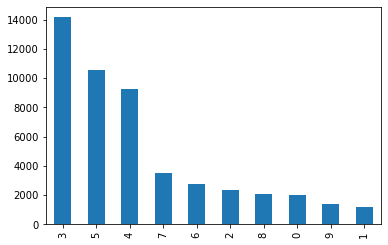

In [46]:
#riduzione dei generi top a 10 (il task che abbiamo scelto)

#df_originale = df.copy()

from sklearn.preprocessing import LabelEncoder

label_encoders = dict()
column2encode = []#['ALBUM_type_']

for col in column2encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    
df = df[df.TRACK_genre_top.isna() == False] #droppo i nulli

label_encoders = dict()
column2encode = ['TRACK_genre_top']

for col in column2encode:
    le = LabelEncoder()
    df['TRACK_genre_top_num'] = le.fit_transform(df[col])
    label_encoders[col] = le
    
df['TRACK_genre_top_num']=[0 if genre == 3 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 0 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 14 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 2 else genre for genre in df['TRACK_genre_top_num']]



df['TRACK_genre_top_num']=[0 if genre == 15 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 11 else genre for genre in df['TRACK_genre_top_num']]
df['TRACK_genre_top_num']=[0 if genre == 10 else genre for genre in df['TRACK_genre_top_num']]


df['TRACK_genre_top_num']=[3 if genre == 13 else genre for genre in df['TRACK_genre_top_num']] #rock 13 --> 3
df['TRACK_genre_top_num']=[2 if genre == 12 else genre for genre in df['TRACK_genre_top_num']] #pop 12 --> 2

df.TRACK_genre_top_num.value_counts().plot(kind='bar')

# Recupero dei generi con le NN (miglior risultato task 2)

In [47]:
import math
import scipy.stats as stats
import seaborn as sn
import IPython.display as ipd
import ast
import keras
import tensorflow as tf

from pandas.api.types import CategoricalDtype
from collections import Counter
from collections import defaultdict
from imblearn.under_sampling import RandomUnderSampler
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from pandas.api.types import CategoricalDtype
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_roc
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from tqdm.notebook import tqdm, trange
from collections import defaultdict
from scipy.stats.stats import pearsonr
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler


def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [48]:
tf.debugging.set_log_device_placement(False)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [49]:
class_name = 'TRACK_genre_top_num'

attributes = Diff(compl + bitmap, [class_name]) #Diff(compl + features, ('ALBUM_favorites_', 'ALBUM_listens_', 'TRACK_number', 'TRACK_interest'))
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

#--------------Oversampling:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

#ros = RandomOverSampler(random_state=42)
#X_res, y_res = ros.fit_resample(X_train, y_train)


#sm = SMOTE(random_state=42)
#X_res, y_res = sm.fit_resample(X_train, y_train)


#-------------Undersampling
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler

#rus = RandomUnderSampler(random_state=42)
#X_res, y_res = rus.fit_resample(X_train, y_train)



X_res = X_train
y_res = y_train


scaler = StandardScaler()
#scaler = MinMaxScaler()
#scaler = RobustScaler()

scaler.fit(X_res)
X_res = scaler.transform(X_res)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)



unique, counts = np.unique(y_train, return_counts=True)
print("train", dict(zip(unique, counts)))

unique, counts = np.unique(y_res, return_counts=True)
print("bilanciato", dict(zip(unique, counts)))

unique, counts = np.unique(y_val, return_counts=True)
print("validation", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("test", dict(zip(unique, counts)))


#Trasformo la target value in vettore con 1 sulla posizione del genere giusto
y_res = tf.keras.utils.to_categorical(y_res, 10)
y_val = tf.keras.utils.to_categorical(y_val, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

train {0: 1455, 1: 859, 2: 1667, 3: 10104, 4: 6664, 5: 7685, 6: 2029, 7: 2529, 8: 1495, 9: 990}
bilanciato {0: 1455, 1: 859, 2: 1667, 3: 10104, 4: 6664, 5: 7685, 6: 2029, 7: 2529, 8: 1495, 9: 990}
validation {0: 377, 1: 232, 2: 425, 3: 2635, 4: 1669, 5: 1805, 6: 467, 7: 653, 8: 368, 9: 239}
test {0: 204, 1: 121, 2: 233, 3: 1416, 4: 926, 5: 1054, 6: 277, 7: 354, 8: 207, 9: 136}


In [50]:
# FUNZIONE PER COSTRUIRE LA NN
def costruisci(n_layer_crescenti=5, initialHiddenLayer=128, n_layer_decrescenti = 5, finalHiddenLayer=128):
    model = Sequential()
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation='relu'))
    
    for n in range(1, n_layer_crescenti+1):
        model.add(Dense(initialHiddenLayer*(n), activation='relu'))
        print("creo layer crescente di dimensione ", initialHiddenLayer*(n))
    for n in range(n_layer_decrescenti , 0, -1):
        model.add(Dense(finalHiddenLayer*(n), activation='relu'))
        print("creo layer decrescente di dimensione ", finalHiddenLayer*(n))
        
    model.add(Dense(y_res.shape[1], activation=tf.nn.softmax))

    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) #<-- binario
    model.compile(loss='categorical_crossentropy', 
                  metrics=['accuracy'],
                  optimizer='adam',
                 )
    
    return model

In [57]:
model = costruisci(n_layer_crescenti=2, 
                   initialHiddenLayer=1500,
                      n_layer_decrescenti = 1,
                      finalHiddenLayer=1200)

es = EarlyStopping(monitor='val_loss', patience=10)
mc = ModelCheckpoint('best_model_NOREG.h5', monitor='val_loss', save_best_only=True)


history1 = model.fit(X_res, y_res, epochs=1000, 
                      #batch_size= 128,
                      validation_data=(X_val, y_val), callbacks=[es,mc]
                     ).history

creo layer crescente di dimensione  1500
creo layer crescente di dimensione  3000
creo layer decrescente di dimensione  1200
Epoch 1/1000
1109/1109 [==============================] - 11s 10ms/step - loss: 0.9881 - accuracy: 0.7011 - val_loss: 0.4308 - val_accuracy: 0.8638
Epoch 2/1000
1109/1109 [==============================] - 6s 6ms/step - loss: 0.3596 - accuracy: 0.8803 - val_loss: 0.3813 - val_accuracy: 0.8848
Epoch 3/1000
1109/1109 [==============================] - 6s 6ms/step - loss: 0.2600 - accuracy: 0.9155 - val_loss: 0.4585 - val_accuracy: 0.8698
Epoch 4/1000
1109/1109 [==============================] - 6s 6ms/step - loss: 0.2272 - accuracy: 0.9251 - val_loss: 0.3972 - val_accuracy: 0.8887
Epoch 5/1000
1109/1109 [==============================] - 6s 6ms/step - loss: 0.1845 - accuracy: 0.9392 - val_loss: 0.4252 - val_accuracy: 0.8811
Epoch 6/1000
1109/1109 [==============================] - 6s 6ms/step - loss: 0.1637 - accuracy: 0.9468 - val_loss: 0.4001 - val_accuracy: 0.89

In [53]:
y_pred = model.predict(X_test)

y_pred_bool = np.argmax(y_pred, axis=1) #si deve usare argmax o predict_classes
y_test_bool = np.argmax(y_test, axis=1)

print(classification_report(y_test_bool, y_pred_bool))

# rumore 4 --> avremmo solo .1-.2% nulli
#2 3000 2 800 ---------> .73 .73 (acc, f1)
#1 3000 1 800 ---------> .78 .79
#1 1500 1 400 ---------> .80 .79
#1 1100 1 300 ---------> .74 .76
#1 1100 1 500 ---------> .80 .79
#1 1100 1 900 ---------> .75 .75
#1 1500 1 900 ---------> .78 .77
#1 1500 2 400 ---------> .80 .80
#1 2000 2 400 ---------> .82 .81
#1 4000 2 400 ---------> .74 .71
#1 4000 4 400 ---------> .80 .78

# rumore 3
#1 1000 1 500 ---------> .81 .80 (acc, f1)
#1 1500 1 800 ---------> .85 .85 (acc, f1)
#1 3000 2 400 ---------> .76 .74 (acc, f1)
#1 2500 2 1200 ---------> .85 .85 (acc, f1)
#2 1500 1 1200 ---------> .90 .89


# confusione 2
#1 1500 1 700 ---------> .89 .89


#89/90 no s
#

              precision    recall  f1-score   support

           0       0.84      0.78      0.81       204
           1       0.97      0.82      0.89       121
           2       0.84      0.62      0.71       233
           3       0.91      0.97      0.94      1416
           4       0.89      0.91      0.90       926
           5       0.93      0.91      0.92      1054
           6       0.83      0.87      0.85       277
           7       0.90      0.87      0.88       354
           8       0.80      0.83      0.81       207
           9       0.88      0.84      0.86       136

    accuracy                           0.90      4928
   macro avg       0.88      0.84      0.86      4928
weighted avg       0.90      0.90      0.89      4928



In [55]:
X_test.shape


(4928, 867)

In [28]:
attributes

['FEATURES_chroma_censmax07',
 'ALBUM_tracks_=149.0',
 'ALBUM_date_released_year_=2016.0',
 'ALBUM_date_released_year_=2010.5',
 'FEATURES_mfccmin18',
 'FEATURES_spectral_contrastmin06',
 'ALBUM_tracks_=224.0',
 'FEATURES_mfccskew13',
 'FEATURES_mfccmin14',
 'FEATURES_spectral_contrastmin01',
 'FEATURES_tonnetzmax05',
 'FEATURES_chroma_cqtkurtosis08',
 'FEATURES_spectral_centroidmean01',
 'FEATURES_mfccmedian15',
 'ALBUM_tracks_=192.0',
 'ALBUM_tracks_=186.0',
 'FEATURES_chroma_cqtmin05',
 'FEATURES_chroma_cqtmin09',
 'ALBUM_date_released_year_=1971.0',
 'FEATURES_mfcckurtosis17',
 'FEATURES_chroma_cqtmean01',
 'FEATURES_mfccmax09',
 'FEATURES_chroma_cqtmax01',
 'FEATURES_chroma_stftskew02',
 'FEATURES_mfccmean15',
 'FEATURES_tonnetzmedian01',
 'ALBUM_tracks_=25.0',
 'FEATURES_chroma_censmax02',
 'FEATURES_chroma_censmedian05',
 'FEATURES_tonnetzstd04',
 'ALBUM_tracks_=12.0',
 'FEATURES_spectral_contrastmean04',
 'FEATURES_spectral_contrastskew07',
 'FEATURES_chroma_censmax03',
 'ALBUM

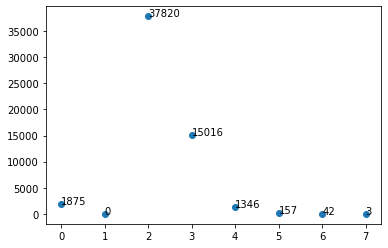

In [29]:
n = []

for i in range(8):
    n.append(len(df0[(df0.TRACK_genre_top.isna()) & (df0.TRACK_genres_soloTop_len == i)].index))
    
fig, ax = plt.subplots()
ax.scatter(y=n, x=list(range(8)))

for i, txt in enumerate(n):
    ax.annotate(txt, (list(range(8))[i], n[i]))


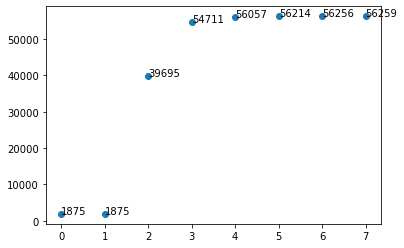

In [30]:
n2 = np.cumsum(n)

fig, ax = plt.subplots()
ax.scatter(y=n2, x=list(range(8)))

for i, txt in enumerate(n2):
    ax.annotate(txt, (list(range(8))[i], n2[i]))